# Prepare data for streamlit
Based on the `create_data.ipynb` notebook, this notebook does some final preprocessing steps to the data so it fits with streamlit.

### Setup

In [1]:
from pathlib import Path
import sys

from glhmm.utils import get_visits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from utils.data_io import load_from_pkl, save_to_pkl
from utils.data_types import calculate_min_t
from utils.plots import stc_snippet_plot
from utils.utils import viterbi_path_to_stc


# Variables and parameters
data_path = Path('C:/Users/tobia/Documents/dev/Thesis/thesis/data')

hmm_states = 12
embedded_lags = 7
min_t = calculate_min_t(data_path, embedded_lags)
indices = np.expand_dims(np.array([0, min_t]), axis=0)

In [2]:
# Load dark and bright- room data
run_date = '2023-05-19'

data_bright = load_from_pkl(Path(f'data/processed_data/data_bright-room_{run_date}.pkl'))
data_dark = load_from_pkl(Path(f'data/processed_data/data_dark-room_{run_date}.pkl'))

constants = [str(2**i) for i in range(-5, 15+1)]
constants_dict = {}
for constant_idx, constant in enumerate(constants):
    constants_dict[constant] = constant_idx - 5

In [3]:
def create_vp_state_mask(viterbi_path, low_tresh=0, upper_thresh=np.inf):
    """Remove states that are shorter or longer than thresholds"""
    mask = np.full([len(viterbi_path)], True)
    for state in range(hmm_states):
        lengths, onsets = get_visits(viterbi_path_to_stc(viterbi_path, hmm_states), state)
        for length, onset in zip(lengths, onsets):
            if length < low_tresh or length > upper_thresh:
                mask[onset:onset+int(length)] = False
    
    return mask

In [4]:
def pupil_preprocessing(pupil):
    """Preprocess the pupil (apply session mask afterwards manually)
    Session mask should be applied afterwards.
    """
    pupil = scipy.stats.zscore(pupil)
    pupil = scipy.signal.detrend(pupil)
    
    return pupil

Create masks for bad pupil data

In [5]:
for session_idx, session in enumerate(data_dark):
    session.mask = np.full(len(session.pupil), True)
    
    if session_idx == 1:
        session.mask[:7494] = False
        
    elif session_idx == 5:
        session.mask[52000:59800] = False
        
    elif session_idx == 7:
        session.mask[39868:] = False
        
    elif session_idx == 10:
        session.mask[59500:61500] = False
    
    elif session_idx == 12:
        session.mask[70200:70700] = False
        
    elif session_idx == 13:
        session.mask[41284:] = False
        
    elif session_idx == 14:
        session.mask[:10995] = False
        
    elif session_idx == 16:
        session.mask[55900:] = False
        
    elif session_idx == 17:
        session.mask[:1000] = False

for session_idx, session in enumerate(data_bright):
    session.mask = np.full(len(session.pupil), True)
    
    if session_idx == 5:
        session.mask[:1000] = False
        
    elif session_idx == 7:
        session.mask[:2000] = False
        
    elif session_idx == 9:
        session.mask[-1000:] = False

### HMM fit data

In [12]:
from glhmm.utils import get_switching_rate, get_visits

def summarize_fit(data_dark, data_bright, stat_type, constants, hmm_states):
    conditions_list = []
    constants_list = []
    session_idx_list = []
    states_list = []
    data_list = []
    
    for condition in ['Dark room', 'Bright room']:
        data = data_dark if condition == 'Dark room' else data_bright
        for constant_idx, constant in enumerate(constants):
            for session_idx, session in enumerate(data):
                
                if stat_type == 'fo':
                    viterbi_path = session.hmm[constant]['viterbi_path'][session.mask]
                    for state in range(hmm_states):
                        fo = len(viterbi_path[viterbi_path == state]) / len(viterbi_path)
                        data_list.append(fo)
                        
                elif stat_type == 'sr':
                    gamma = session.hmm[constant]['gamma'][session.mask]
                    indices = np.expand_dims(np.array([0, gamma.shape[0]]), axis=0)
                    sr = get_switching_rate(gamma, indices)[0]
                    data_list.extend(sr.tolist())
                
                elif stat_type == 'dt':
                    viterbi_path = session.hmm[constants[constant_idx]]['viterbi_path'][session.mask]
                    
                    for state in range(hmm_states):
                        lengths, _ = get_visits(viterbi_path_to_stc(viterbi_path, hmm_states), state)
                        # Convert to seconds and get the mean
                        dt = np.mean(np.array(lengths) / 250)
                        data_list.append(dt)
                    
                conditions_list.extend([condition for _ in range(hmm_states)])
                constants_list.extend([constant_idx for _ in range(hmm_states)])
                session_idx_list.extend([session_idx for _ in range(hmm_states)])
                states_list.extend([state for state in range(hmm_states)])
    
    result = pd.DataFrame({
        'condition': conditions_list,
        'constant': constants_list,
        'session_idx': session_idx_list,
        'state': states_list,
        stat_type: data_list,
    })
    
    return result

In [15]:
# Fractional occupancies
save_to_pkl(
    summarize_fit(data_dark, data_bright, 'fo', constants, hmm_states),
    "streamlit_data/fo_df.pkl"
)

# Switching rate
save_to_pkl(
    summarize_fit(data_dark, data_bright, 'sr', constants, hmm_states),
    'streamlit_data/sr_df.pkl'
)

# Dwell times
save_to_pkl(
    summarize_fit(data_dark, data_bright, 'dt', constants, hmm_states),
    'streamlit_data/dt_df.pkl'
)

### Pupil sizes
How are the pupil sizes distributed?

In [53]:
def summarize_pupil_sizes_by_state(data_dark, data_bright, hmm_states):
    conditions_list = []
    states_list = []
    stat_list = []
    pupil_size_list = []
    
    for condition in ['Dark room', 'Bright room']:
        data = data_dark if condition == 'Dark room' else data_bright
        for stat in ['Mean', 'Median', 'SD']:
            for state in range(hmm_states):
                session_pupils = []
                
                for session in data:
                    pupil = session.pupil
                    pupil = scipy.stats.zscore(pupil)
                    pupil = pupil[session.mask]
                    
                    session_pupils.extend(pupil[session.hmm[constant]['viterbi_path'][session.mask] == state].tolist())
                    
                    if stat == 'Mean':
                        ps = np.mean(session_pupils)
                    if stat == 'Median':
                        ps = np.median(session_pupils)
                    if stat == 'SD':
                        ps = np.std(session_pupils)
                
                conditions_list.append(condition)
                states_list.append(state)
                stat_list.append(stat)
                pupil_size_list.append(ps)
                
    result = pd.DataFrame({
        'condition': conditions_list,
        'state': states_list,
        'stat': stat_list,
        'pupil_size': pupil_size_list,
    })
    
    return result

def summarize_pupil_sizes_by_session_and_state(data_dark, data_bright, hmm_states):
    conditions_list = []
    sessions_list = []
    states_list = []
    stat_list = []
    pupil_size_list = []
    
    for condition in ['Dark room', 'Bright room']:
        data = data_dark if condition == 'Dark room' else data_bright
        for stat in ['Mean', 'Median', 'SD']:
            for state in range(hmm_states):
                for session_idx, session in enumerate(data):
                    pupil = session.pupil
                    pupil = scipy.stats.zscore(pupil)
                    pupil = pupil[session.mask]
                    
                    pupil = pupil[session.hmm[constant]['viterbi_path'][session.mask] == state]
                    
                    if stat == 'Mean':
                        ps = np.mean(pupil)
                    if stat == 'Median':
                        ps = np.median(pupil)
                    if stat == 'SD':
                        ps = np.std(pupil)
                
                    conditions_list.append(condition)
                    sessions_list.append(session_idx)
                    states_list.append(state)
                    stat_list.append(stat)
                    pupil_size_list.append(ps)
                
    result = pd.DataFrame({
        'condition': conditions_list,
        'session': sessions_list,
        'state': states_list,
        'stat': stat_list,
        'pupil_size': pupil_size_list,
    })
    
    return result

In [54]:
# State-wise pupil sizes
save_to_pkl(
    summarize_pupil_sizes_by_state(data_dark, data_bright, hmm_states),
    "streamlit_data/ps_state_df.pkl"
)

# Session-state-wise pupil sizes
save_to_pkl(
    summarize_pupil_sizes_by_session_and_state(data_dark, data_bright, hmm_states),
    "streamlit_data/ps_session_df.pkl"
)

### Snippet of STC with pupil overlay
To get a better idea of what the data looks like, we can overlay the raw and filtered pupil signal on top of a viterbi path.

In [63]:
def stc_snippet_plot(ax, data, session_idx, constant, data_path, start_sec, sec, hmm_states):
    import seaborn as sns
    import matplotlib as mpl
    # Color settings
    color_dark = '#3282B8'
    color_bright = '#BBE1FA'
    
    # Setup fonts
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    
    # Get pupil and VP for plotting
    pupil = data[session_idx].pupil
    #pupil = pupil_preprocessing(pupil)
    viterbi_path = data[session_idx].hmm[constant]['viterbi_path']

    # Read the raw pupil signal
    pupil_path = Path(f"{data_path}/Pupil/subj{data[session_idx].subject}_sess{data[session_idx].session}.mat")
    pupil_file = scipy.io.loadmat(pupil_path)
    pupil_raw = pupil_file['pupil'][:, 0]
    pupil_phase = pupil_file['pupil_phase'][:, 0]
    
    # Create time-points
    t_start = start_sec * 250
    t_end = t_start + sec * 250
    
    # Put data together in a dataframe
    pupil_df = pd.DataFrame({
        't': 2 * [t / 250 for t in range(sec * 250)],
        'pupil': pupil_raw[t_start:t_end].tolist() + pupil[t_start:t_end].tolist(),
        'type': ['pupil_raw' for _ in range(sec * 250)] + ['pupil_filtered' for _ in range(sec * 250)],
    })

    # Plot pupil signal
    sns.lineplot(
        pupil_df.query("type == 'pupil_raw'"),
        x         = 't',
        y         = 'pupil',
        ax        = ax,
        color     = 'red',
        linewidth = 0.6,
        alpha     = 0.9,
    )

    sns.lineplot(
        pupil_df.query("type == 'pupil_filtered'"),
        x         = 't',
        y         = 'pupil',
        ax        = ax,
        color     = '#4C72B0',
        linewidth = 1.5,
        alpha     = 1.0,
    )

    # Overlay activation of states
    for state in [3, 4]:
        lengths, visits = get_visits(viterbi_path_to_stc(viterbi_path, hmm_states), state)

        for visit_idx, visit in enumerate(visits):
            if visit >= t_start and visit <= t_end:
                plt.axvspan(
                    xmin  = (visit-t_start) / 250,
                    xmax  = (visit+lengths[visit_idx]-t_start) / 250,
                    color = color_bright if state == 3 else color_dark,
                    alpha = 0.3
                )

    # Setup custom legends
    custom_groups = ['Posterior DMN 1', 'Posterior DMN 2', 'Raw pupil', 'Processed pupil']

    custom_handles = []
    custom_handles.append(ax.scatter([], [], label='Posterior DMN 1', c=color_bright, s=50, alpha=0.8))
    custom_handles.append(ax.scatter([], [], label='Posterior DMN 2', c=color_dark, s=50, alpha=0.8))
    custom_handles.append(ax.plot([], [], label='Raw pupil', color='red', lw=2, alpha=0.9)[0])
    custom_handles.append(ax.plot([], [], label='Processed pupil', color='#4C72B0', lw=2, alpha=0.9)[0])

    ax.legend(custom_handles, custom_groups, loc='center left', bbox_to_anchor=(1.0, 0.75), title=None, frameon=False)

    # Final layout adjustments
    ax.set(
        title='Time courses for pupil and state visits',
        xlabel = 'Time [s]',
        ylabel = 'Pupil size'
    )

    sns.despine()

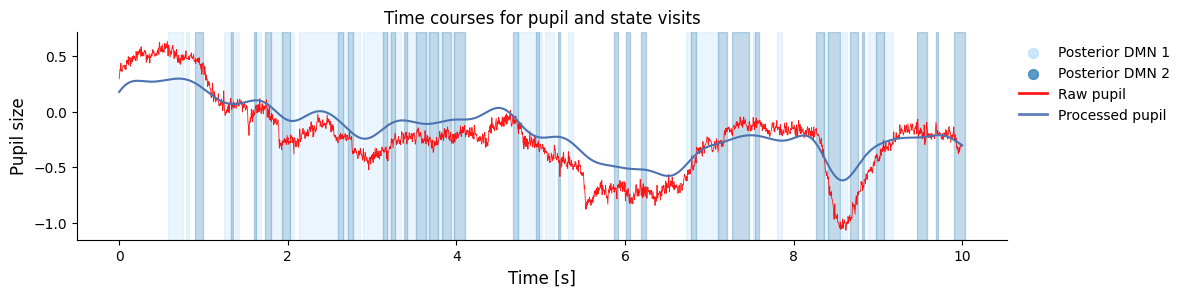

In [64]:
constant_idx = 5
session_idx  = 1
start_sec    = 90
sec          = 10

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 2.7))

stc_snippet_plot(ax1, data_dark, session_idx, constants[constant_idx], data_path, start_sec, sec, hmm_states)

fig.savefig("streamlit_data/stc", dpi=300, bbox_inches='tight')

### One-vs-Rest
Are there any significant effects when comparing the pupil size of one state against all other states?

In [38]:
def calculate_dilation_difference(viterbi_path, pupil, state, stat):
    start_indexes = np.where((viterbi_path[:-1] != state) & (viterbi_path[1:] == state))[0] + 1
    end_indexes = np.where((viterbi_path[:-1] == state) & (viterbi_path[1:] != state))[0]
    
    if stat == 'Median':
        state_pupil_start = np.median(pupil[start_indexes])
        state_pupil_end = np.median(pupil[end_indexes])
    elif stat == 'Mean':
        state_pupil_start = np.mean(pupil[start_indexes])
        state_pupil_end = np.mean(pupil[end_indexes])
    else:
        raise ValueError("Error")
    
    difference = state_pupil_end - state_pupil_start
    
    return difference

def calculate_baseline_difference(viterbi_path, pupil, state, stat):
    if stat == 'Median':
        state_pupil = np.median(pupil[viterbi_path == state])
        other_pupil = np.median(pupil[viterbi_path != state])
    elif stat == 'Mean':
        state_pupil = np.mean(pupil[viterbi_path == state])
        other_pupil = np.mean(pupil[viterbi_path != state])
    elif stat == 'SD':
        state_pupil = np.std(pupil[viterbi_path == state])
        other_pupil = np.std(pupil[viterbi_path != state])
    elif stat == 'Min-Max':
        state_pupil = np.max(pupil[viterbi_path == state]) - np.min(pupil[viterbi_path == state])
        other_pupil = np.max(pupil[viterbi_path != state]) - np.min(pupil[viterbi_path != state])
    else:
        raise ValueError("Error")
    
    difference = state_pupil - other_pupil
    
    return difference

def one_vs_rest_p_values(data, constants, hmm_states, test, stat):
    p_values = np.zeros([len(constants), len(data), hmm_states])

    for constant_idx, constant in enumerate(constants):
        for session_idx, session in enumerate(data):
            permutations = session.hmm[constant]['permutations']
            #pupil = scipy.stats.zscore(session.pupil)
            #pupil = scipy.signal.detrend(pupil)
            pupil = pupil[session.mask]
            
            for state in range(hmm_states):
                permutation_distribution = np.zeros([len(permutations)])
                for permutation_idx, viterbi_path in enumerate(permutations):
                    if test == 'Baseline':
                        permutation_distribution[permutation_idx] = calculate_baseline_difference(viterbi_path[session.mask], pupil, state, stat)
                    elif test == 'Dilation':
                        permutation_distribution[permutation_idx] = calculate_dilation_difference(viterbi_path[session.mask], pupil, state, stat)
                    else:
                        raise ValueError("Error")
                    
                viterbi_path = session.hmm[constant]['viterbi_path'][session.mask]
                if test == 'Baseline':
                    true_difference = calculate_baseline_difference(viterbi_path, pupil, state, stat)
                elif test == 'Dilation':
                    true_difference = calculate_dilation_difference(viterbi_path, pupil, state, stat)
                else:
                    raise ValueError("Error")
                
                cdf = scipy.stats.norm.cdf(true_difference, np.mean(permutation_distribution), np.std(permutation_distribution))
                p = 1 - cdf

                if p < 0.0001:
                    p = 0.0001 # sys.float_info.min
                elif p > 1 - 0.0001:
                    p = 1 - 0.0001 # sys.float_info.min
                
                p_values[constant_idx, session_idx, state] = p
    
    return p_values

In [39]:
condition_list = []
stat_list = []
constants_list = []
direction_list = []
state_list = []
p_list = []

for condition in ['Dark room', 'Bright room']:
    for stat in ['Mean', 'Median', 'SD', 'Min-Max']:
        p_values = one_vs_rest_p_values(
            data_dark if condition == 'Dark room' else data_bright,
            constants, hmm_states, "Baseline", stat)
        
        for constant_idx, constant in enumerate(constants):
            for direction in ['Positive', 'Negative']:
                for state in range(hmm_states):
                    if direction == 'Negative':
                        #p = scipy.stats.combine_pvalues(1 - p_values[constant_idx, :, state], method='fisher')
                        #p = p.pvalue
                        p = scipy.stats.mstats.gmean(
                            np.array(1 - p_values[constant_idx, :, state]).T,
                            nan_policy='omit'
                        )
                    else:
                        #p = scipy.stats.combine_pvalues(p_values[constant_idx, :, state], method='fisher')
                        #p = p.pvalue
                        p = scipy.stats.mstats.gmean(
                            np.array(p_values[constant_idx, :, state]).T,
                            nan_policy='omit'
                        )
                    
                    condition_list.append(condition)
                    stat_list.append(stat)
                    constants_list.append(constant_idx - 5)
                    direction_list.append(direction)
                    state_list.append(state)
                    p_list.append(p)

ovr_df = pd.DataFrame({
    'condition': condition_list,
    'stat': stat_list,
    'constant': constants_list,
    'direction': direction_list,
    'state': state_list,
    'p': p_list,
})

In [41]:
ovr_df.to_csv('streamlit_data/ovr_df.csv', index=False)

### Dilation / Constriction

In [55]:
condition_list = []
stat_list = []
constants_list = []
direction_list = []
state_list = []
p_list = []

for condition in ['Dark room', 'Bright room']:
    for stat in ['Mean', 'Median']:
        p_values = one_vs_rest_p_values(
            data_dark if condition == 'Dark room' else data_bright,
            constants, hmm_states, "Dilation", stat)
        
        for constant_idx, constant in enumerate(constants):
            for direction in ['Positive', 'Negative']:
                for state in range(hmm_states):
                    if direction == 'Negative':
                        #p = scipy.stats.combine_pvalues(1 - p_values[constant_idx, :, state], method='fisher')
                        #p = p.pvalue
                        p = scipy.stats.mstats.gmean(
                            np.array(1 - p_values[constant_idx, :, state]).T,
                            nan_policy='omit'
                        )
                    else:
                        #p = scipy.stats.combine_pvalues(p_values[constant_idx, :, state], method='fisher')
                        #p = p.pvalue
                        p = scipy.stats.mstats.gmean(
                            np.array(p_values[constant_idx, :, state]).T,
                            nan_policy='omit'
                        )
                    
                    condition_list.append(condition)
                    stat_list.append(stat)
                    constants_list.append(constant_idx - 5)
                    direction_list.append(direction)
                    state_list.append(state)
                    p_list.append(p)

dilation_df = pd.DataFrame({
    'condition': condition_list,
    'stat': stat_list,
    'constant': constants_list,
    'direction': direction_list,
    'state': state_list,
    'p': p_list,
})

In [56]:
dilation_df.to_csv('streamlit_data/dilation_df.csv', index=False)

### State pairs (One-vs-One)
Are there any significant effects when comparing state pairs?

In [57]:
def calculate_statepair_difference(viterbi_path, pupil, state_1, state_2, stat):
    if stat == 'Mean':
        state_1_pupil = pupil[viterbi_path == state_1].mean()
        state_2_pupil = pupil[viterbi_path == state_2].mean()
    elif stat == 'Median':
        state_1_pupil = np.median(pupil[viterbi_path == state_1])
        state_2_pupil = np.median(pupil[viterbi_path == state_2])
    else:
        raise ValueError("Error")
    
    difference = state_1_pupil - state_2_pupil
    
    return difference

def one_vs_one_p_values(data, constants, hmm_states, stat):
    p_values = np.zeros([len(constants), len(data), hmm_states, hmm_states])

    for constant_idx, constant in enumerate(constants):
        for session_idx, session in enumerate(data):
            permutations = session.hmm[constant]['permutations']
            pupil = scipy.stats.zscore(session.pupil)
            pupil = scipy.signal.detrend(pupil)
            pupil = pupil[session.mask]
            for state_1 in range(hmm_states-1):
                for state_2 in range(state_1+1, hmm_states):
                    permutation_distribution = np.zeros([len(permutations)])
                    for permutation_idx, viterbi_path in enumerate(permutations):
                        permutation_distribution[permutation_idx] = calculate_statepair_difference(viterbi_path[session.mask], pupil, state_1, state_2, stat)

                    viterbi_path = session.hmm[constant]['viterbi_path'][session.mask]
                    true_difference = calculate_statepair_difference(viterbi_path, pupil, state_1, state_2, stat)
                    
                    cdf = scipy.stats.norm.cdf(true_difference, np.mean(permutation_distribution), np.std(permutation_distribution))
                    
                    # State 1 > state 2
                    p = 1 - cdf
                    p_values[constant_idx, session_idx, state_1, state_2] = p if p != 0 else sys.float_info.min
                    # State 2 > state 1
                    p_values[constant_idx, session_idx, state_2, state_1] = cdf if cdf != 0 else sys.float_info.min
    
    return p_values

In [58]:
dark_svs_mean = one_vs_one_p_values(data_dark, constants, hmm_states, 'Mean')
bright_svs_mean = one_vs_one_p_values(data_bright, constants, hmm_states, 'Mean')
dark_svs_median = one_vs_one_p_values(data_dark, constants, hmm_states, 'Median')
bright_svs_median = one_vs_one_p_values(data_bright, constants, hmm_states, 'Median')

In [60]:
dark_svs_mean_2 = np.zeros([len(constants), hmm_states, hmm_states])
for constant_idx, _ in enumerate(constants):
    dark_svs_mean_2[constant_idx] = scipy.stats.mstats.gmean(
        np.array(dark_svs_mean[constant_idx]),
        nan_policy='omit'
    )
save_to_pkl(dark_svs_mean_2, "streamlit_data/dark_svs_mean.pkl")

bright_svs_mean_2 = np.zeros([len(constants), hmm_states, hmm_states])
for constant_idx, _ in enumerate(constants):
    bright_svs_mean_2[constant_idx] = scipy.stats.mstats.gmean(
        np.array(bright_svs_mean[constant_idx]),
        nan_policy='omit'
    )
save_to_pkl(bright_svs_mean_2, "streamlit_data/bright_svs_mean.pkl")

dark_svs_median_2 = np.zeros([len(constants), hmm_states, hmm_states])
for constant_idx, _ in enumerate(constants):
    dark_svs_median_2[constant_idx] = scipy.stats.mstats.gmean(
        np.array(dark_svs_median[constant_idx]),
        nan_policy='omit'
    )
save_to_pkl(dark_svs_median_2, "streamlit_data/dark_svs_median.pkl")

bright_svs_median_2 = np.zeros([len(constants), hmm_states, hmm_states])
for constant_idx, _ in enumerate(constants):
    bright_svs_median_2[constant_idx] = scipy.stats.mstats.gmean(
        np.array(bright_svs_median[constant_idx]),
        nan_policy='omit'
    )
save_to_pkl(bright_svs_median_2, "streamlit_data/bright_svs_median.pkl")